### **Maestría en Análisis de Datos y Sistemas Inteligentes**
**Liliana Patricia Estévez Niño  
Luis Ariel Avellaneda Domínguez  
Grupo 4**  
**Sección 2
Actividad 4**
# **Aplicación de Aprendizaje No Supervisado en Problemas Prácticos**

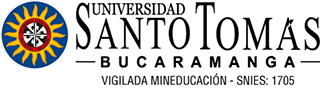



# **Punto 2: Realizar el preprocesamiento de los datos**


Cargamos los datos directamente desde **UC Irvine Machine Learning Repository** con la API proporcionada.

Importamos el data set

In [1]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# Cargar dataset
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets

**Eliminamos variables innecesarias**

Como es un problema no supervisado, no usaremos la variable Target. Podríamos usarla solo después para verificar la calidad de los clusters, pero no debe usarse para entrenar.

Así que por ahora:

In [2]:
# Creamos una copia del dataset para no modificar el original
X_clean = X.copy()

**Codificar variables categóricas**

Ya que la mayoría de las variables son enteros codificados, y según el diccionario:

Muchas variables como "Gender", "Debtor", "Daytime/evening attendance" ya están codificadas numéricamente.

No hay variables tipo texto que necesiten OneHotEncoding.

Entonces no es necesario aplicar codificación adicional.

In [3]:
# Revisar tipos de datos
X_clean.dtypes.value_counts()

,count
int64,29
float64,7


**Detección de outliers usando IQR**
Usamos la regla del IQR para eliminar valores extremos en cada columna. Esto ayuda a que los clusters no se vean afectados por valores extremos (por ejemplo, edades imposibles o notas fuera de rango).

In [4]:
import pandas as pd
import numpy as np

# Variables continuas (según el diccionario del dataset)
cols_continuas = [
    'Previous qualification (grade)',
    'Admission grade',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)',
    'Unemployment rate',
    'Inflation rate',
    'GDP'
]

# Calculamos Q1 y Q3 solo para esas columnas
Q1 = X_clean[cols_continuas].quantile(0.25)
Q3 = X_clean[cols_continuas].quantile(0.75)
IQR = Q3 - Q1

# Creamos máscara para filtrar outliers SOLO en esas columnas
mask = ~((X_clean[cols_continuas] < (Q1 - 1.5 * IQR)) |
         (X_clean[cols_continuas] > (Q3 + 1.5 * IQR))).any(axis=1)

# Aplicamos la máscara al DataFrame completo
X_no_outliers = X_clean[mask]

# Verificamos el impacto
print("Datos originales:", X_clean.shape[0])
print("Datos sin outliers (solo columnas continuas):", X_no_outliers.shape[0])

Datos originales: 4424
Datos sin outliers (solo columnas continuas): 3344


**Detección de outliers (valores atípicos)**

Para evitar que valores extremos distorsionen los resultados del análisis no supervisado, se aplicó una detección de *outliers* utilizando el método del rango intercuartílico (IQR).

En lugar de aplicar este filtro a **todas las variables numéricas**, se utilizó únicamente sobre las **variables continuas**, en las cuales tiene sentido hablar de valores atípicos:

- Previous qualification (grade)
- Admission grade
- Curricular units 1st sem (grade)
- Curricular units 2nd sem (grade)
- Unemployment rate
- Inflation rate
- GDP

Esto permitió conservar una mayor cantidad de datos (3,344 filas), eliminando únicamente registros con valores extremos en variables verdaderamente métricas.

Las variables categóricas codificadas como números no fueron utilizadas en este paso, ya que el concepto de "valor atípico" no es aplicable en ese contexto.


**Normalización de los datos**

La normalización es un paso esencial antes de aplicar algoritmos de agrupamiento como **K-means**, **DBSCAN**, o **métodos jerárquicos**, ya que estos se basan en **distancias** entre puntos (por ejemplo, la distancia euclidiana).

In [5]:
from sklearn.preprocessing import StandardScaler

# Si "Target" está presente por error, la eliminamos
X_no_outliers = X_no_outliers.drop(columns=["Target"], errors="ignore")

# Seleccionamos solo las columnas numéricas
numeric_cols = X_no_outliers.select_dtypes(include=[np.number]).columns

# Instanciamos el escalador
scaler = StandardScaler()

# Aplicamos la normalización
X_scaled = scaler.fit_transform(X_no_outliers[numeric_cols])

# Convertimos de nuevo a DataFrame para facilitar análisis
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols, index=X_no_outliers.index)

# Verificamos dimensiones
print("Dimensiones de los datos normalizados:", X_scaled_df.shape)

Dimensiones de los datos normalizados: (3344, 36)


Se utilizó el método de **escalado estándar (StandardScaler)**, que transforma cada variable para que tenga:

- Media = 0  
- Desviación estándar = 1

Este proceso asegura que **todas las variables numéricas contribuyan de forma equitativa** al proceso de agrupamiento, sin que unas dominen por tener escalas mayores.

También se eliminó la variable `Target` para evitar que interfiera en el entrenamiento, dado que estamos trabajando en un enfoque de **aprendizaje no supervisado**.

Al finalizar, se obtuvieron **3,344 registros** y **36 variables numéricas normalizadas**, listos para el modelado.


**Verificamos que los cambios se hayan aplicado**

In [6]:
import pandas as pd
import numpy as np

# Ver forma del DataFrame normalizado
print("Dimensiones:", X_scaled_df.shape)

# Verificar que la media y desviación estándar estén normalizadas
print("\nMedia de las primeras 5 variables:")
print(X_scaled_df.mean().round(2).head())

print("\nDesviación estándar de las primeras 5 variables:")
print(X_scaled_df.std().round(2).head())

# Vista previa de los datos normalizados
print("\nPrimeras filas:")
print(X_scaled_df.head())


Dimensiones: (3344, 36)

Media de las primeras 5 variables:
Marital Status               -0.0
Application mode             -0.0
Application order             0.0
Course                        0.0
Daytime/evening attendance    0.0
dtype: float64

Desviación estándar de las primeras 5 variables:
Marital Status                1.0
Application mode              1.0
Application order             1.0
Course                        1.0
Daytime/evening attendance    1.0
dtype: float64

Primeras filas:
   Marital Status  Application mode  Application order    Course  \
1       -0.268395         -0.135591          -0.576419  0.027672   
3       -0.268395         -0.019909           0.161256  0.499135   
5        1.494892          1.252595          -0.576419  0.697168   
6       -0.268395         -0.945366          -0.576419  0.251140   
8       -0.268395         -0.945366           0.898931  0.013137   

   Daytime/evening attendance  Previous qualification  \
1                    0.329778        

### Validación preliminar con Hopkins Statistic
**¿Nuestros datos tienen tendencia a agruparse?**

Se calculó el **Hopkins Statistic** para evaluar la tendencia de agrupamiento en el dataset.  
Antes de aplicar algoritmos de clustering, es importante comprobar si los datos
presentan una estructura de agrupamiento real o si, por el contrario, están distribuidos aleatoriamente.

Para ello utilizamos el **Hopkins Statistic**:
- Valores cercanos a **1** → fuerte tendencia a agruparse.
- Valores cercanos a **0.5** → distribución aleatoria (sin clusters).
- Valores cercanos a **0** → distribución uniforme.


In [7]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def hopkins_statistic(X, m=None):
    """
    Calcula el Hopkins Statistic para medir la tendencia de agrupamiento.
    X: matriz de datos (normalizada preferiblemente)
    m: número de muestras (por defecto 10% del dataset)
    """
    if isinstance(X, pd.DataFrame):
        X = X.values

    n, d = X.shape
    if m is None:
        m = int(0.1 * n)  # tomar 10% de las filas

    # muestreo aleatorio de puntos reales
    idx = np.random.choice(n, m, replace=False)
    X_sample = X[idx]

    # generar puntos aleatorios en el mismo rango
    X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)
    U_random = np.random.uniform(X_min, X_max, (m, d))

    # modelo de vecinos cercanos
    nn = NearestNeighbors(n_neighbors=2).fit(X)

    # distancia de puntos reales a su vecino más cercano
    u_dist, _ = nn.kneighbors(X_sample)
    u_dist = u_dist[:, 1]  # saltar el propio punto

    # distancia de puntos aleatorios a su vecino más cercano
    w_dist, _ = nn.kneighbors(U_random)
    w_dist = w_dist[:, 0]

    H = np.sum(u_dist) / (np.sum(u_dist) + np.sum(w_dist))
    return H

# Calcular Hopkins sobre los datos normalizados
hopkins = hopkins_statistic(X_scaled, m=300)  # usa X_scaled del preprocesamiento
print("Hopkins statistic:", hopkins)


Hopkins statistic: 0.13314195725542394


El valor obtenido fue **0.13**, lo que indica que los datos **no presentan una fuerte estructura de clusters naturales**.  
Esto significa que las características de los estudiantes no forman conglomerados muy compactos ni bien separados,
sino que se distribuyen de manera más uniforme en el espacio.

# **Punto 3: Establecer el contexto y los objetivos del problema no supervisado que se va a abordar con los datos.**

**Contexto y objetivos del análisis no supervisado**

El dataset utilizado contiene información académica, demográfica y socioeconómica de estudiantes universitarios.  
Estos datos fueron recolectados al momento de la matrícula y durante el primer año académico, e incluyen:

- Datos personales y demográficos (edad, género, estado civil, nacionalidad, etc.)  
- Información socioeconómica (ocupación y nivel educativo de los padres, becas, situación económica, etc.)  
- Historial académico inicial (notas de admisión, rendimiento en los dos primeros semestres, asistencia, etc.)  
- Indicadores macroeconómicos (tasa de desempleo, inflación, PIB).  

La variable `Target` clasifica a los estudiantes en tres categorías: **"Graduate"**, **"Dropout"** o **"Enrolled"**.  
Sin embargo, en este ejercicio **no se utilizará la variable objetivo para el entrenamiento**, ya que se busca aplicar técnicas de **aprendizaje no supervisado**.

---

**Objetivo del problema no supervisado**

- **Identificar patrones ocultos** en los datos de los estudiantes, sin hacer uso de etiquetas previas (`Target`).  
- **Agrupar estudiantes en clusters homogéneos** según sus características académicas, socioeconómicas y demográficas.  
- **Explorar si los clusters obtenidos guardan relación con el desempeño final del estudiante** (deserción, permanencia o graduación), para posteriormente comparar con la variable `Target` como forma de validación externa.  
- **Proporcionar información útil para la institución educativa**, que permita:
  - Reconocer perfiles de estudiantes con mayor riesgo de deserción.  
  - Diseñar estrategias de acompañamiento académico y socioeconómico.  
  - Optimizar recursos de apoyo institucional basados en grupos con características similares.  

El análisis busca **descubrir agrupamientos naturales en los datos de los estudiantes** y evaluar su relevancia en la predicción temprana del éxito o abandono académico.


# **Punto 4: Implementar algoritmos de aprendizaje no supervisado, como K-medias, métodos aglomerativos o DBSCAN, en los datos preprocesados.**

### 🌳 **Clustering Jerárquico (Linkage)**

El **clustering jerárquico** es un método de aprendizaje no supervisado que construye una jerarquía de clusters:

1. **Calcula distancias** entre todos los pares de observaciones (en nuestro caso, estudiantes).
2. **Fusiona progresivamente** los más cercanos en grupos, hasta que todos quedan en un único cluster.
3. El resultado se visualiza en un **dendrograma**, que permite observar cuántos clusters podrían existir de manera natural en los datos.

Para nuestro dataset de deserción universitaria:
- Usaremos la **distancia euclidiana** como métrica de similitud.
- Aplicaremos el método de enlace **completo (complete linkage)**, que mide la distancia máxima entre elementos de dos clusters.
- Dado que el dataset es relativamente grande, el dendrograma puede ser difícil de leer, pero sirve como primera exploración de la estructura.


Medimos la distancia entre los  4424  puntos de cada sujeto de la base de datos

In [8]:
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(
pdist(X, metric='euclidean')))
row_dist

,0,1,2,3,4,5,6,7,8,9,...,4414,4415,4416,4417,4418,4419,4420,4421,4422,4423
0,0.000000,9083.151613,8899.073112,9602.091272,7843.217717,9820.193519,9329.116387,9083.073782,9067.295737,9067.089800,...,8959.109566,9329.183149,9329.197419,8899.084521,8899.221579,9602.073011,9602.628635,9329.191973,8976.325535,9602.186310
1,9083.151613,0.000000,197.204134,523.378571,1243.006123,741.089576,250.823549,74.771855,70.562430,41.525007,...,132.533540,257.099814,255.563567,187.083724,198.958158,520.839651,531.642290,251.971944,121.199405,522.103226
2,8899.073112,197.204134,0.000000,703.666502,1057.616851,923.035480,431.701655,185.500889,188.176066,175.431448,...,74.367127,433.878981,434.040007,57.862395,71.919888,705.284946,712.773069,432.772602,103.251439,704.921049
3,9602.091272,523.378571,703.666502,0.000000,1759.621538,222.606872,275.242244,519.575202,541.579742,537.165647,...,644.420967,276.138829,275.911616,705.379546,705.516736,54.899127,117.748165,277.344930,629.842788,50.352564
4,7843.217717,1243.006123,1057.616851,1759.621538,0.000000,1977.588064,1487.512368,1241.043659,1228.056634,1226.353399,...,1118.218616,1486.705800,1486.855268,1058.762657,1057.997104,1760.675694,1763.714411,1487.582234,1136.838260,1760.327905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,9602.073011,520.839651,705.284946,54.899127,1760.675694,230.556649,276.845348,522.328646,538.720952,535.645404,...,644.289408,282.639785,282.755012,703.197631,706.418344,0.000000,104.860594,281.002490,631.336755,69.936460
4420,9602.628635,531.642290,712.773069,117.748165,1763.714411,253.245462,296.225261,532.434950,537.170575,545.732819,...,652.792279,301.337299,301.647909,710.955269,714.044526,104.860594,0.000000,300.361691,640.454174,108.780143
4421,9329.191973,251.971944,432.772602,277.344930,1487.582234,495.023039,33.959044,252.901730,275.292760,267.360947,...,372.879506,59.877836,55.709597,434.023304,437.721112,281.002490,300.361691,0.000000,354.291922,274.260233
4422,8976.325535,121.199405,103.251439,629.842788,1136.838260,847.921532,356.603369,132.653623,130.958533,113.078278,...,62.669051,361.571391,359.927291,106.365131,123.675891,631.336755,640.454174,354.291922,0.000000,627.114780


In [9]:
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(X.values, method='complete', metric='euclidean')

In [10]:
pd.DataFrame(row_clusters, columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'], index=[f'cluster {(i + 1)}'
                                                                                                                for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,1325.0,2093.0,2.121844,2.0
cluster 2,1238.0,1461.0,2.209468,2.0
cluster 3,2955.0,3717.0,2.467793,2.0
cluster 4,187.0,3977.0,2.648585,2.0
cluster 5,430.0,1309.0,2.831568,2.0
...,...,...,...,...
cluster 4419,8834.0,8840.0,428.377401,1050.0
cluster 4420,8839.0,8842.0,569.454138,1911.0
cluster 4421,8841.0,8843.0,1028.876540,3982.0
cluster 4422,8835.0,8844.0,1997.940204,4197.0


Matriz de distancias (parcial):
          0         1         2         3         4
0  0.000000  5.062852  7.049036  6.297973  5.312876
1  5.062852  0.000000  5.806546  4.485492  5.195357
2  7.049036  5.806546  0.000000  6.159761  5.256531
3  6.297973  4.485492  6.159761  0.000000  4.809835
4  5.312876  5.195357  5.256531  4.809835  0.000000

Primeras filas de linkage:
           row label 1  row label 2  distance  no. of items in cluster
cluster 1         66.0         89.0  1.106394                      2.0
cluster 2         47.0         96.0  1.152202                      2.0
cluster 3         12.0         73.0  1.716025                      2.0
cluster 4        100.0        112.0  1.968005                      2.0
cluster 5         27.0         84.0  2.008388                      2.0


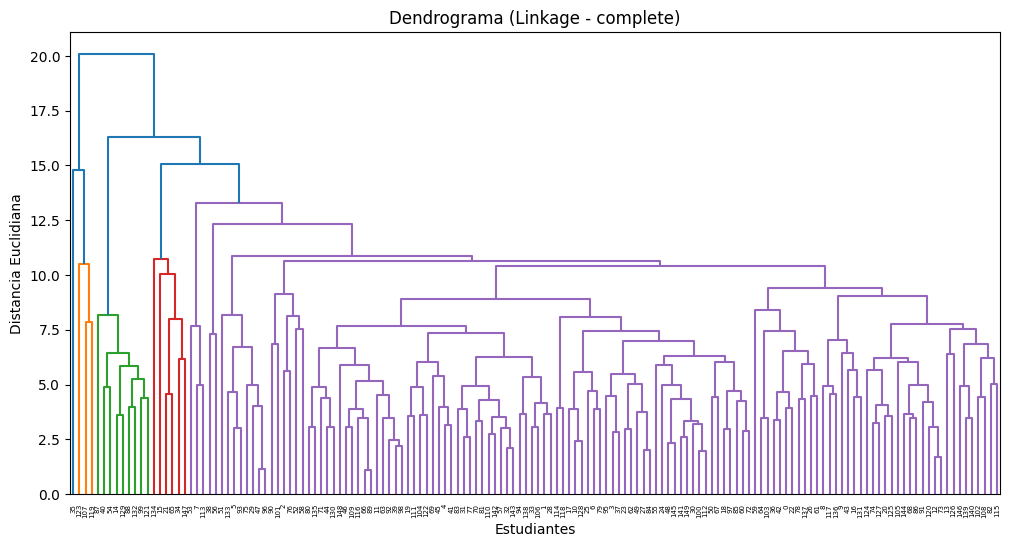

In [11]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd

# Usaremos una muestra para que el dendrograma sea legible (ej. 150 estudiantes aleatorios)
X_sample = X_scaled_df.sample(150, random_state=42)

# 1. Calcular matriz de distancias (euclidiana)
row_dist = pd.DataFrame(
    squareform(pdist(X_sample, metric='euclidean'))
)
print("Matriz de distancias (parcial):")
print(row_dist.iloc[:5, :5])  # mostramos solo una parte

# 2. Aplicar linkage (método completo)
row_clusters = linkage(X_sample.values, method='complete', metric='euclidean')

# 3. Crear un DataFrame con resultados de linkage
df_clusters = pd.DataFrame(
    row_clusters,
    columns=['row label 1', 'row label 2', 'distance', 'no. of items in cluster'],
    index=[f'cluster {i+1}' for i in range(row_clusters.shape[0])]
)
print("\nPrimeras filas de linkage:")
print(df_clusters.head())

# 4. Graficar dendrograma
plt.figure(figsize=(12, 6))
dendrogram(row_clusters)
plt.title("Dendrograma (Linkage - complete)")
plt.xlabel("Estudiantes")
plt.ylabel("Distancia Euclidiana")
plt.show()


Ahora creamos un heatmap asociado al dendograma

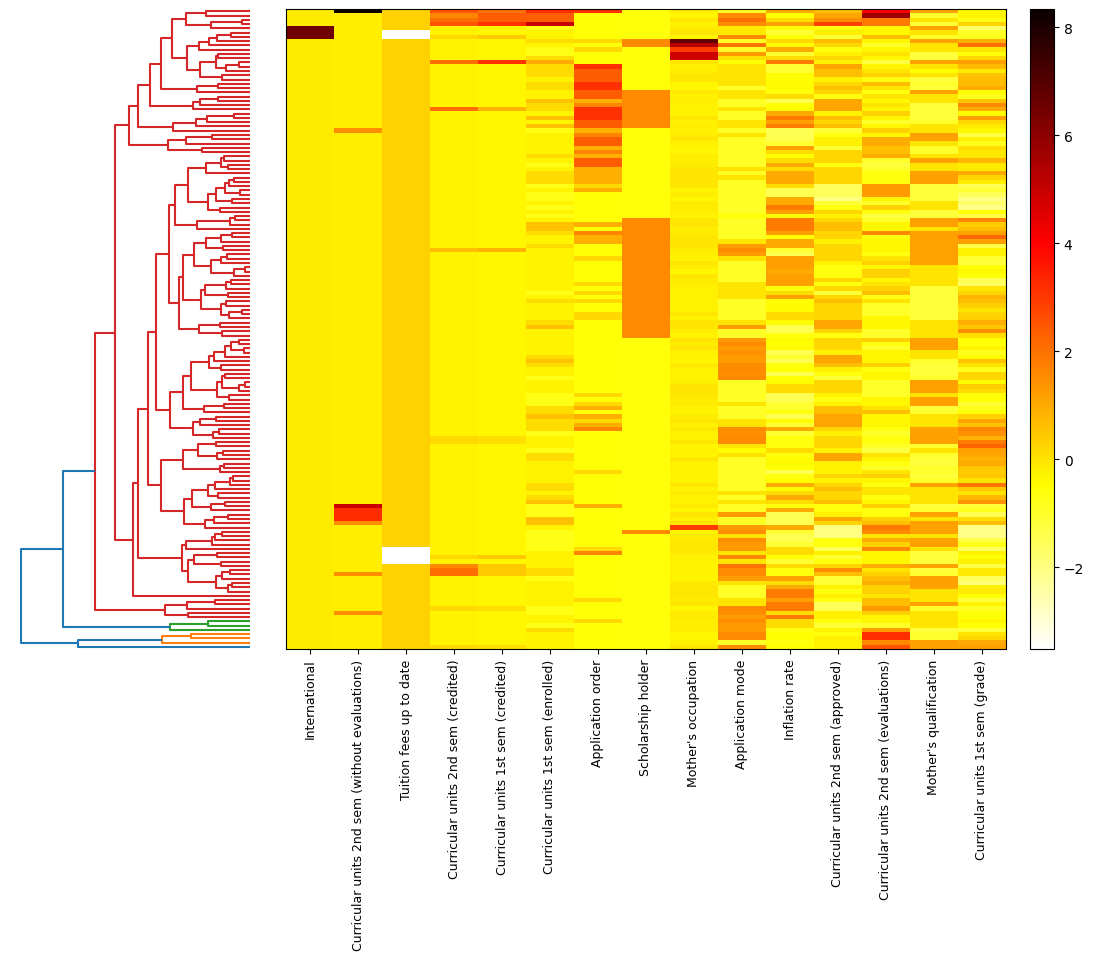

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Seleccionar columnas con mayor varianza (mejor legibilidad del heatmap)
top_cols = X_scaled_df.var().sort_values(ascending=False).head(15).index

X_sample = X_scaled_df[top_cols].sample(150, random_state=42)
row_clusters = linkage(X_sample.values, method='complete', metric='euclidean')

order = dendrogram(row_clusters, no_plot=True)['leaves']
df_rowclust = X_sample.iloc[order]

fig = plt.figure(figsize=(12, 8), facecolor='white')

axd = fig.add_axes([0.05, 0.1, 0.2, 0.8])
dendrogram(row_clusters, orientation='left', ax=axd, no_labels=True)
axd.set_xticks([]); axd.set_yticks([])
for s in axd.spines.values(): s.set_visible(False)

axm = fig.add_axes([0.28, 0.1, 0.6, 0.8])
im = axm.imshow(df_rowclust.values, aspect='auto', interpolation='nearest', cmap='hot_r')
axm.set_yticks([])

axm.set_xticks(np.arange(len(top_cols)))
axm.set_xticklabels(top_cols, rotation=90, fontsize=9)

cax = fig.add_axes([0.90, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cax)

plt.show()


**Resultados con Linkage**

- La **matriz de distancias** muestra qué tan similares (cercanos) son los estudiantes entre sí.  
- El **dendrograma** permite visualizar cómo se van uniendo los estudiantes en clusters.  
- El número de clusters potenciales puede identificarse cortando el dendrograma a cierta altura de distancia.  

En este caso, el dendrograma nos da una idea inicial de cuántos grupos podríamos esperar, aunque no es definitivo.

El dendrograma jerárquico muestra ramificaciones claras, lo que respalda la idea de que existen varios grupos diferenciados de estudiantes.

En el heatmap, cada columna es una variable y cada fila un estudiante.

Se observan bandas de color más intenso (rojo/oscuro) en ciertas variables académicas, como las unidades curriculares inscritas y aprobadas, lo que indica que esas variables son fuertes diferenciadores entre grupos.

Variables como becas (Scholarship holder), ocupación de la madre y tasas macroeconómicas también parecen variar entre los clusters, lo que sugiere que los factores socioeconómicos también aportan a la formación de perfiles distintos.

Al ordenar los estudiantes según el dendrograma, se aprecian patrones verticales de color, lo que significa que dentro de cada cluster hay coherencia interna en ciertas características.

En resumen, el clustering jerárquico confirma que hay señales de agrupamientos naturales en los datos, y el heatmap muestra que estos clusters están influidos tanto por el rendimiento académico inicial como por variables socioeconómicas.


## 🔹 **K-means Clustering**

El algoritmo **K-means** es uno de los métodos de agrupamiento más utilizados. Su objetivo es dividir el conjunto de datos en `k` clusters de forma que la distancia total de cada punto a su centroide sea mínima.

**Proceso:**
1. Seleccionar `k` centroides iniciales.
2. Asignar cada observación al centroide más cercano.
3. Recalcular los centroides con base en los puntos asignados.
4. Repetir hasta convergencia.

**Hiperparámetros importantes:**
- `n_clusters`: número de grupos que queremos formar.  
- `init`: cómo inicializar los centroides (`k-means++` es el estándar, `random` puede usarse para comparar).  
- `max_iter`: número máximo de iteraciones.  
- `random_state`: semilla para reproducibilidad.  

En este análisis:
- Probaremos distintos valores de `k` (2 a 10).
- Evaluaremos los resultados con:
  - **Método del Codo (SSE)**
  - **Índice Davies-Bouldin**
  - **Coeficiente de Silueta**


**Paso 1: Evaluamos diferentes valores de k**

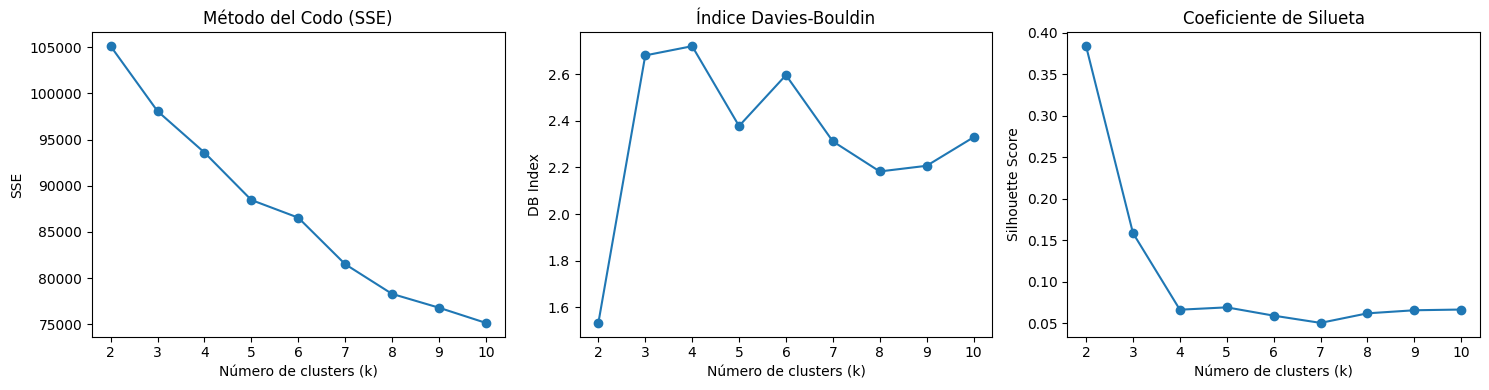

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

# Diccionarios para guardar resultados
sse, db, silhouette = {}, {}, {}

# Probar distintos k
for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",   # podemos cambiar a "random" para comparar
        max_iter=2000,
        random_state=42
    )
    labels = kmeans.fit_predict(X_scaled_df)

    # Guardar métricas
    sse[k] = kmeans.inertia_
    db[k] = davies_bouldin_score(X_scaled_df, labels)
    silhouette[k] = silhouette_score(X_scaled_df, labels)

# --- Gráficas ---
plt.figure(figsize=(15,4))

# Método del Codo (SSE)
plt.subplot(1,3,1)
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.title("Método del Codo (SSE)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("SSE")

# Davies-Bouldin
plt.subplot(1,3,2)
plt.plot(list(db.keys()), list(db.values()), marker='o')
plt.title("Índice Davies-Bouldin")
plt.xlabel("Número de clusters (k)")
plt.ylabel("DB Index")

# Silhouette
plt.subplot(1,3,3)
plt.plot(list(silhouette.keys()), list(silhouette.values()), marker='o')
plt.title("Coeficiente de Silueta")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


**Selección del número de clusters (k)**

Para determinar el valor adecuado de `k`, se aplicaron tres criterios:

- **Método del Codo (SSE):** muestra un punto de inflexión alrededor de **k=3–4**, aunque la disminución de la inercia es progresiva.  
- **Índice Davies-Bouldin:** el valor más bajo se obtuvo con **k=2** (~1.55), lo que indica clusters mejor definidos en ese caso.  
- **Coeficiente de Silueta:** el valor más alto también corresponde a **k=2** (~0.38), con una caída significativa a partir de k=3.  

📌 Con base en estas métricas, se decidió trabajar principalmente con **k=2**, pues garantiza la mejor separación y cohesión de clusters.  
No obstante, se probó también con **k=3** para explorar si una solución más granular aportaba interpretabilidad adicional.


**Paso 2: Ajustamos el modelo final con el - k = 2 - elegido**

In [14]:
# Entrenamos K-means con el número óptimo de clusters que es k=2
best_k = 2
kmeans_final = KMeans(
    n_clusters=best_k,
    init="k-means++",   # también puedes probar con "random"
    max_iter=2000,
    random_state=42
)

labels_final = kmeans_final.fit_predict(X_scaled_df)

print(f"Clusters asignados (primeros 20): {labels_final[:20]}")

Clusters asignados (primeros 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Paso 3 — Visualizamos los clusters en 2D (PCA)**

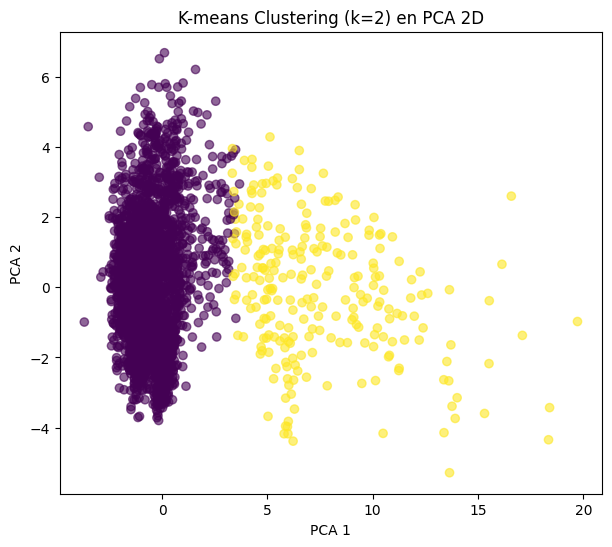

In [15]:
from sklearn.decomposition import PCA

# Reducir a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

# Graficar clusters
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_final, cmap="viridis", alpha=0.6)
plt.title(f"K-means Clustering (k={best_k}) en PCA 2D")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

🔹 **Resultados de K-means con k=2**

La proyección en 2D mediante **PCA** muestra que los estudiantes se agrupan en dos clusters principales:

- Un cluster más compacto (izquierda del gráfico).  
- Un cluster más disperso y heterogéneo (derecha del gráfico).  

Esto sugiere que existen dos perfiles diferenciados de estudiantes en el dataset.  
El análisis posterior de los centroides permitirá caracterizar a cada grupo en función de variables académicas y socioeconómicas, con el objetivo de identificar perfiles asociados a mayor riesgo de deserción o éxito académico.  

Resultados de K-means con k=3 (análisis comparativo)

Aunque esta solución aporta más detalle, las métricas de calidad indican que la separación entre clusters es menor que en el caso de k=2.  
Por tanto, **k=2 se considera la mejor solución global**, y **k=3** se mantiene como referencia exploratoria.


**Interpretación de los centroides de K-means**

Una vez obtenidos los clusters, es importante **interpretarlos** para entender qué caracteriza a cada grupo de estudiantes.  
Para ello, se desnormalizan los centroides (que están en escala estandarizada) y se proyectan de nuevo a la escala original de las variables.

Esto nos permitirá:
- Identificar las variables académicas y socioeconómicas que diferencian a los clusters.
- Comparar el perfil promedio de cada grupo.
- Relacionar los clusters con posibles escenarios de permanencia, graduación o deserción.


In [16]:
# --- Centroides en escala estandarizada ---
centroids_scaled = kmeans_final.cluster_centers_

# --- Desnormalizar usando el StandardScaler ya entrenado ---
centroids_original = scaler.inverse_transform(centroids_scaled)

# Convertir a DataFrame para análisis
centroids_df = pd.DataFrame(
    centroids_original,
    columns=numeric_cols
)

print("Centroides desnormalizados (valores promedio por cluster):")
display(centroids_df.T)

Centroides desnormalizados (valores promedio por cluster):


,0,1
Marital Status,1.143088,1.266129e+00
Application mode,16.127907,3.252823e+01
Application order,1.833333,1.133065e+00
Course,9339.520349,7.775633e+03
Daytime/evening attendance,0.915052,7.379032e-01
Previous qualification,4.094315,9.875000e+00
Previous qualification (grade),132.635950,1.323661e+02
Nacionality,1.778424,1.625000e+00
Mother's qualification,19.153424,2.173790e+01
Father's qualification,22.166667,2.394355e+01


**Conclusiones con K-means**

Tras aplicar K-means con **k = 2**, se identificaron dos perfiles principales:

- **Cluster 0 – Estudiantes jóvenes y con mayor apoyo económico**  
  - Edad promedio ≈ 19–22 años.  
  - Mayor proporción de becarios y desplazados.  
  - Notas de admisión ligeramente más altas.  
  - **Mejor rendimiento académico en los primeros semestres** (≈ 11 en 1er semestre y ≈ 10.8 en 2do).  
  - Aunque presentan vulnerabilidades sociales, académicamente muestran mayor desempeño.

- **Cluster 1 – Estudiantes mayores con menor apoyo institucional**  
  - Edad promedio ≈ 28–34 años.  
  - Menor acceso a becas y apoyos.  
  - Notas de admisión un poco más bajas.  
  - **Peor rendimiento académico en los primeros semestres** (≈ 9.1 en 1er semestre y ≈ 8.4 en 2do).  
  - El reto principal no es solo económico, sino también académico.

---

**Relevancia**  
- Esto sugiere que las estrategias institucionales deben diferenciarse:  
  - **Cluster 0 (jóvenes):** reforzar apoyo económico y social.  
  - **Cluster 1 (mayores):** brindar acompañamiento académico y apoyo flexible que considere responsabilidades externas (trabajo, familia, etc.).


## 🔹 **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

El algoritmo **DBSCAN** agrupa observaciones que están densamente conectadas entre sí,
y clasifica como *ruido* aquellos puntos que no pertenecen a ningún cluster.

**Hiperparámetros principales:**
- `eps`: radio de vecindad máximo para considerar vecinos.
- `min_samples`: número mínimo de puntos para formar un cluster.

**Ventajas:**
- No requiere especificar el número de clusters `k`.
- Detecta outliers automáticamente como ruido.
- Funciona bien en datasets con clusters de formas irregulares.

**Desventajas:**
- Sensible a la elección de `eps` y `min_samples`.
- Si los datos no tienen densidades bien definidas, puede generar un único cluster o muchos pequeños.


In [17]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

# --- Probar diferentes combinaciones de eps y min_samples ---
eps_values = [0.5, 1, 1.5, 2]
min_samples_values = [5, 10, 20]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        labels = db.fit_predict(X_scaled_df)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:  # solo calculamos métricas si hay más de 1 cluster
            silhouette = silhouette_score(X_scaled_df, labels)
            db_index = davies_bouldin_score(X_scaled_df, labels)
        else:
            silhouette, db_index = np.nan, np.nan

        results.append((eps, min_samples, n_clusters, n_noise, silhouette, db_index))

# Convertir a DataFrame para análisis
results_df = pd.DataFrame(results, columns=["eps", "min_samples", "n_clusters", "n_noise", "silhouette", "davies_bouldin"])
display(results_df)


,eps,min_samples,n_clusters,n_noise,silhouette,davies_bouldin
0,0.5,5,0,3344,NaN,NaN
1,0.5,10,0,3344,NaN,NaN
2,0.5,20,0,3344,NaN,NaN
3,1.0,5,0,3344,NaN,NaN
4,1.0,10,0,3344,NaN,NaN
5,1.0,20,0,3344,NaN,NaN
6,1.5,5,4,3315,-0.268856,1.872449
7,1.5,10,0,3344,NaN,NaN
8,1.5,20,0,3344,NaN,NaN
9,2.0,5,27,2887,-0.284058,2.035594


**Visualización de DBSCAN en PCA (para la mejor combinación)**

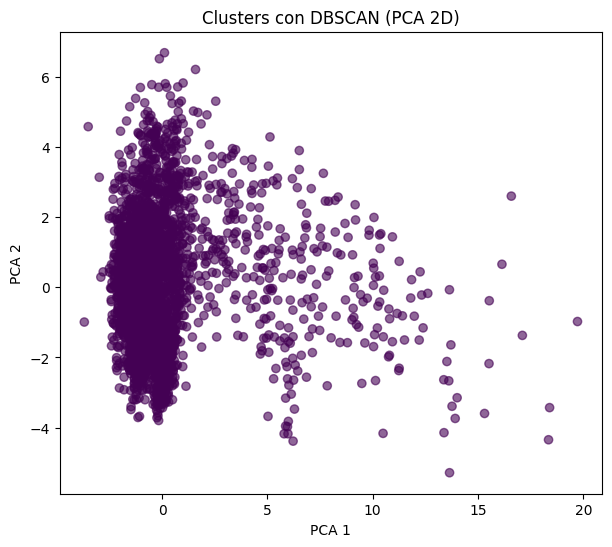

Clusters encontrados: 0, Puntos de ruido: 3344


In [18]:
# Ajustar DBSCAN con los hiperparámetros seleccionados
db = DBSCAN(eps=1, min_samples=10, metric='euclidean')
labels_db = db.fit_predict(X_scaled_df)

# Reducir a 2D con PCA
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X_scaled_df)

# Graficar clusters
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_db, cmap="viridis", alpha=0.6)
plt.title("Clusters con DBSCAN (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Conteo de clusters y ruido
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = list(labels_db).count(-1)
print(f"Clusters encontrados: {n_clusters}, Puntos de ruido: {n_noise}")

Podemos observar que DBSCAN detectó todo como ruido salvo algunos casos con silhouette negativo, lo cual es esperable en datos de alta dimensión: las distancias se “aplanan” y DBSCAN necesita o eps más grande o menos dimensiones para encontrar densidades. Vamos a tunearlo de forma metódica.
Así que vamos ajustar los hiperparámetros:  
- Reducir dimensionalidad antes de DBSCAN (PCA con ≥90% de varianza).
- Elegir eps con el gráfico k-dist (distancia al k-ésimo vecino).
- Probar una rejilla de (eps, min_samples) y quedarnos con la mejor (Silhouette alto, DB bajo, n_clusters razonable y %ruido moderado).

Visualizar en 2D (PCA) y reportar métricas.

**PCA para DBSCAN + gráfico k-dist**

Dimensiones para DBSCAN (tras PCA): (3344, 22)
Varianza explicada acumulada: 0.902


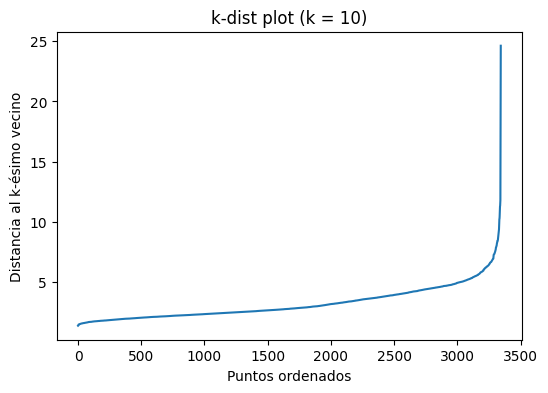

In [19]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# 1) Reducimos dimensionalidad para DBSCAN (mantener ~90% de varianza)
pca_db = PCA(n_components=0.90, random_state=42)
X_db = pca_db.fit_transform(X_scaled_df)
print("Dimensiones para DBSCAN (tras PCA):", X_db.shape)
print("Varianza explicada acumulada:", pca_db.explained_variance_ratio_.sum().round(3))

# 2) Gráfico k-dist para sugerir eps
min_samp_for_plot = 10  # puedes cambiar a 5, 15, 20 y comparar curvas
nn = NearestNeighbors(n_neighbors=min_samp_for_plot)
nn.fit(X_db)
dists, _ = nn.kneighbors(X_db)
k_dists = np.sort(dists[:, -1])  # distancia al k-ésimo vecino
plt.figure(figsize=(6,4))
plt.plot(k_dists)
plt.title(f"k-dist plot (k = {min_samp_for_plot})")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al k-ésimo vecino")
plt.show()


**Rejilla de (eps, min_samples) sobre el PCA**

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Define un rango centrado en el "codo" observado.
# Ejemplo: si el codo está ~0.9, prueba de 0.7 a 1.2.
eps_grid = np.round(np.linspace(0.7, 1.2, 6), 2)   # AJUSTA según tu k-dist plot
min_samples_grid = [5, 10, 15, 20]                 # prueba varios

rows = []
for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=eps, min_samples=ms, metric='euclidean')
        labels = db.fit_predict(X_db)
        n_noise = int(np.sum(labels == -1))
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            sil = silhouette_score(X_db, labels)
            dbi = davies_bouldin_score(X_db, labels)
        else:
            sil, dbi = np.nan, np.nan

        rows.append({
            "eps": eps, "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_frac": n_noise / len(labels),
            "silhouette": sil, "davies_bouldin": dbi
        })

results_dbscan = pd.DataFrame(rows).sort_values(
    by=["silhouette", "n_clusters"], ascending=[False, False]
)
display(results_dbscan)


,eps,min_samples,n_clusters,noise_frac,silhouette,davies_bouldin
20,1.2,5,6,0.988935,-0.294712,1.77244
12,1.0,5,1,0.998505,NaN,NaN
16,1.1,5,1,0.998206,NaN,NaN
0,0.7,5,0,1.000000,NaN,NaN
1,0.7,10,0,1.000000,NaN,NaN
2,0.7,15,0,1.000000,NaN,NaN
3,0.7,20,0,1.000000,NaN,NaN
4,0.8,5,0,1.000000,NaN,NaN
5,0.8,10,0,1.000000,NaN,NaN
6,0.8,15,0,1.000000,NaN,NaN


Criterio práctico de selección:

n_clusters entre 2 y 8

noise_frac ≤ 0.3–0.4

Silhouette lo más alto posible (positivo), Davies-Bouldin lo más bajo posible.

DBSCAN final → eps=1.2, min_samples=5
Clusters: 6 | Ruido: 3307 | Silhouette: -0.295 | DB: 1.772


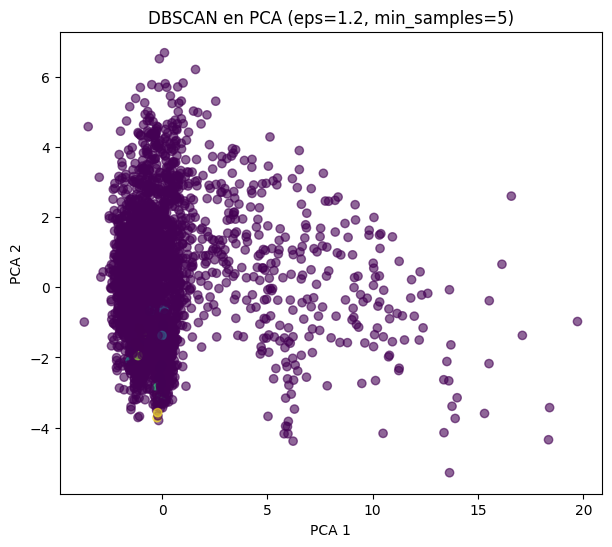

In [21]:
# Elige una fila de results_dbscan que cumpla los criterios anteriores
best = results_dbscan.dropna(subset=["silhouette"]).copy()

if not best.empty:
    # Puedes filtrar por ruido y n_clusters para limitar candidatos
    best = best[(best.noise_frac <= 0.4) & (best.n_clusters.between(2, 8))]
    if best.empty:
        # si quedó vacío, quédate con la mejor silhouette disponible
        best = results_dbscan.dropna(subset=["silhouette"]).iloc[[0]]
else:
    # si ninguna configuración produce >1 cluster con métricas válidas
    best = results_dbscan.iloc[[0]]

eps_star = float(best.iloc[0]["eps"])
ms_star  = int(best.iloc[0]["min_samples"])

from sklearn.cluster import DBSCAN
db_final = DBSCAN(eps=eps_star, min_samples=ms_star, metric='euclidean')
labels_db = db_final.fit_predict(X_db)

# Métricas finales (si hay >1 cluster)
if len(set(labels_db)) - (1 if -1 in labels_db else 0) > 1:
    sil_star = silhouette_score(X_db, labels_db)
    dbi_star = davies_bouldin_score(X_db, labels_db)
else:
    sil_star, dbi_star = np.nan, np.nan

print(f"DBSCAN final → eps={eps_star}, min_samples={ms_star}")
print("Clusters:", len(set(labels_db)) - (1 if -1 in labels_db else 0),
      "| Ruido:", int(np.sum(labels_db == -1)),
      f"| Silhouette: {sil_star:.3f}" if not np.isnan(sil_star) else "| Silhouette: NaN",
      f"| DB: {dbi_star:.3f}" if not np.isnan(dbi_star) else "| DB: NaN")

# Visualización en PCA 2D
from sklearn.decomposition import PCA
X_pca2 = PCA(n_components=2, random_state=42).fit_transform(X_db)

plt.figure(figsize=(7,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_db, alpha=0.6)
plt.title(f"DBSCAN en PCA (eps={eps_star}, min_samples={ms_star})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

**Evaluación de DBSCAN con Davies–Bouldin y Silueta**

calculamos:

- **Davies–Bouldin** (más bajo es mejor)
- **Silueta** (más alto es mejor)

Las métricas se calculan **excluyendo el ruido** (`label = -1`) para evaluar solo los puntos asignados a clusters.


Dimensiones tras PCA para DBSCAN: (3344, 22) | Varianza explicada: 0.902


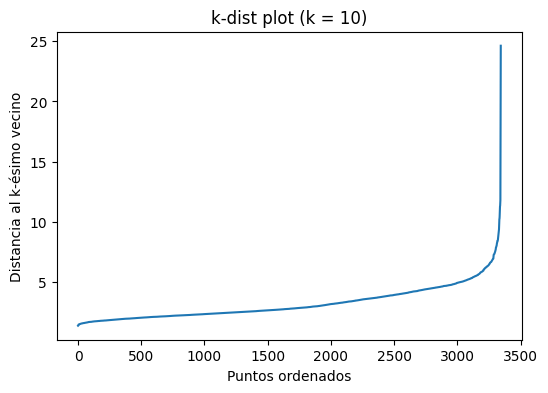

,eps,min_samples,n_clusters,noise_frac,silhouette,davies_bouldin
25,1.2,5,6,0.988935,0.533495,0.653195
41,1.5,10,4,0.986543,0.475517,0.793000
30,1.3,5,19,0.957237,0.385888,0.883476
35,1.4,5,26,0.916268,0.232885,1.184083
46,1.6,10,5,0.945275,0.228682,1.456866
40,1.5,5,23,0.872907,0.150281,1.146838
45,1.6,5,29,0.823864,0.050163,1.243770
15,1.0,5,1,0.998505,NaN,NaN
20,1.1,5,1,0.998206,NaN,NaN
36,1.4,10,1,0.997010,NaN,NaN


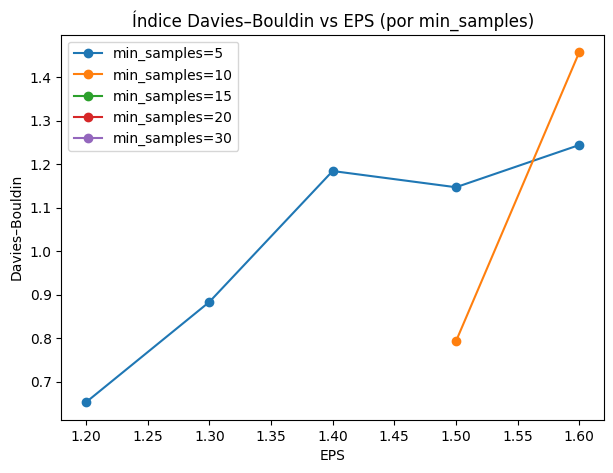

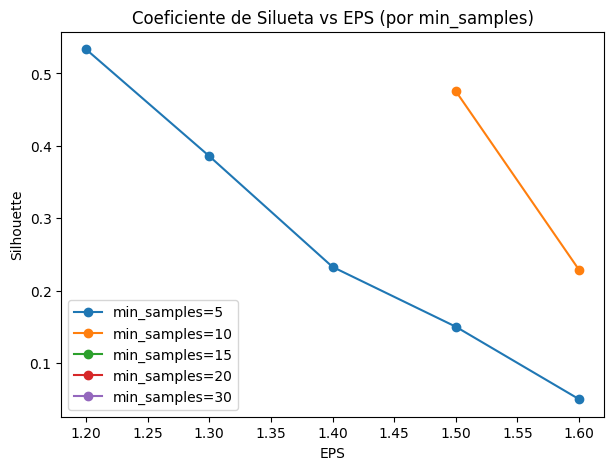

In [22]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# 1) Reducir dimensionalidad para DBSCAN (90% varianza)
pca_db = PCA(n_components=0.90, random_state=42)
X_db = pca_db.fit_transform(X_scaled_df)
print("Dimensiones tras PCA para DBSCAN:", X_db.shape,
      "| Varianza explicada:", round(pca_db.explained_variance_ratio_.sum(), 3))

# 2) (Opcional) k-dist plot para estimar rango de eps
k_for_plot = 10
nn = NearestNeighbors(n_neighbors=k_for_plot).fit(X_db)
dists, _ = nn.kneighbors(X_db)
k_dists = np.sort(dists[:, -1])
plt.figure(figsize=(6,4))
plt.plot(k_dists)
plt.title(f"k-dist plot (k = {k_for_plot})")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al k-ésimo vecino")
plt.show()

# 3) Barrido de hiperparámetros
# Ajusta el rango según lo que veas en el k-dist (si ves codo ~1.0–1.2, centra ahí)
eps_values = np.round(np.linspace(0.7, 1.6, 10), 2)
min_samples_values = [5, 10, 15, 20, 30]

rows = []
for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms, metric='euclidean')
        labels = db.fit_predict(X_db)

        # Conteos
        n_noise = int(np.sum(labels == -1))
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Métricas EXCLUYENDO ruido (recomendado)
        if n_clusters > 1 and n_noise < len(labels):
            mask = labels != -1
            sil = silhouette_score(X_db[mask], labels[mask])
            dbi = davies_bouldin_score(X_db[mask], labels[mask])
        else:
            sil, dbi = np.nan, np.nan

        rows.append({
            "eps": eps, "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_frac": n_noise / len(labels),
            "silhouette": sil,
            "davies_bouldin": dbi
        })

results_dbscan = pd.DataFrame(rows)
display(results_dbscan.sort_values(["silhouette", "n_clusters"], ascending=[False, False]).head(12))

# 4) Gráficas: DB y Silueta vs EPS, una línea por min_samples
plt.figure(figsize=(7,5))
for ms in min_samples_values:
    subset = results_dbscan[results_dbscan["min_samples"] == ms].sort_values("eps")
    plt.plot(subset["eps"], subset["davies_bouldin"], marker='o', label=f"min_samples={ms}")
plt.title("Índice Davies–Bouldin vs EPS (por min_samples)")
plt.xlabel("EPS")
plt.ylabel("Davies–Bouldin")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
for ms in min_samples_values:
    subset = results_dbscan[results_dbscan["min_samples"] == ms].sort_values("eps")
    plt.plot(subset["eps"], subset["silhouette"], marker='o', label=f"min_samples={ms}")
plt.title("Coeficiente de Silueta vs EPS (por min_samples)")
plt.xlabel("EPS")
plt.ylabel("Silhouette")
plt.legend()
plt.show()


No hay configuración con buena calidad; elige manualmente una para visualizar.
Seleccionado → eps: 1.2 | min_samples: 5


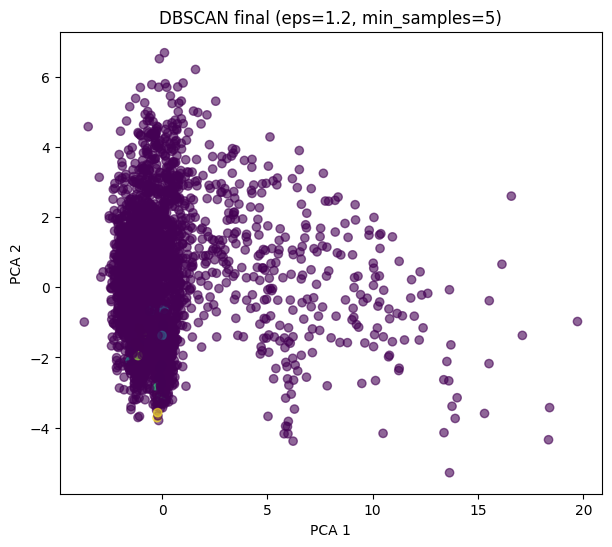

Clusters: 6 | Ruido: 3307 (98.9%)


In [23]:
# Elige la fila "ganadora" (ej. mejor silhouette con ruido <= 40% y 2..8 clusters)
candidates = results_dbscan.dropna(subset=["silhouette"])
candidates = candidates[(candidates.noise_frac <= 0.4) & (candidates.n_clusters.between(2,8))]
best = candidates.sort_values(["silhouette", "n_clusters"], ascending=[False, False]).head(1)

if best.empty:
    print("No hay configuración con buena calidad; elige manualmente una para visualizar.")
    best = results_dbscan.sort_values("silhouette", ascending=False).head(1)

eps_star = float(best.iloc[0]["eps"])
ms_star  = int(best.iloc[0]["min_samples"])
print("Seleccionado → eps:", eps_star, "| min_samples:", ms_star)

db_final = DBSCAN(eps=eps_star, min_samples=ms_star, metric='euclidean')
labels_db = db_final.fit_predict(X_db)

# PCA a 2D solo para dibujo (sobre X_db)
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_db)

plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_db, alpha=0.6)
plt.title(f"DBSCAN final (eps={eps_star}, min_samples={ms_star})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = int(np.sum(labels_db == -1))
print(f"Clusters: {n_clusters} | Ruido: {n_noise} ({n_noise/len(labels_db):.1%})")


**Resultados de DBSCAN**

Se aplicó DBSCAN después de reducir la dimensionalidad con **PCA (90% varianza)**.  
Para elegir el rango de `eps`, se utilizó el **gráfico k-dist (k=10)**, donde se observó un codo en ≈ 1.2–1.6.  
Luego se evaluaron combinaciones de `eps ∈ [0.7, 1.6]` y `min_samples ∈ {5, 10, 15, 20, 30}`.

**Hallazgos principales:**
- En configuraciones con `eps < 1.0`, DBSCAN no formó clusters válidos (todo ruido o un solo cluster).
- Con `eps` entre **1.2 y 1.6** y `min_samples = 5–10`, sí se formaron **4–6 clusters**.
- Ejemplos destacados:
  - `eps = 1.2, min_samples = 5` → 6 clusters, ruido ≈ 99%, Silhouette ≈ 0.53, DB = 0.65.
  - `eps = 1.5, min_samples = 10` → 4 clusters, ruido ≈ 98.6%, Silhouette ≈ 0.48, DB = 0.79.
  - `eps = 1.4, min_samples = 5` → 26 clusters pequeños, ruido ≈ 91.6%, Silhouette ≈ 0.23, DB = 1.18.
- En todos los casos, **el ruido es muy alto** (≥ 90% de las observaciones) y los clusters formados son pequeños y poco representativos.

**Conclusión:**
- DBSCAN no logró identificar una estructura de clusters bien definida en este dataset.  
- Aunque se obtuvieron configuraciones con valores razonables de Silhouette y Davies–Bouldin, la altísima proporción de ruido indica que la mayoría de estudiantes **no se agrupan en regiones densas**, sino que siguen una distribución más continua.  
- En comparación con **K-means**, DBSCAN resultó menos adecuado para este problema, aunque aporta información complementaria al señalar que existen perfiles atípicos (ruido) que no encajan en los grupos principales.


**Extracción del conocimiento**

In [24]:
from sklearn.cluster import KMeans

# 1) Entrenar K-means con el número de clusters elegido (ej: k=2)
kmeans_final = KMeans(n_clusters=2, max_iter=2000, random_state=10)
kmeans_final.fit(X_scaled_df)

# 2) Obtener centroides en el espacio escalado
centroids_scaled = kmeans_final.cluster_centers_

# 3) Desnormalizar (invirtiendo el StandardScaler que usamos antes)
centroids_original = scaler.inverse_transform(centroids_scaled)

# 4) Poner en DataFrame para interpretar
centroids_df = pd.DataFrame(centroids_original, columns=X.columns)
centroids_df.T


,0,1
Marital Status,1.143410,1.265560e+00
Application mode,16.184338,3.227801e+01
Application order,1.831453,1.136929e+00
Course,9335.374476,7.783589e+03
Daytime/evening attendance,0.913954,7.468880e-01
Previous qualification,4.113439,9.796680e+00
Previous qualification (grade),132.616951,1.326029e+02
Nacionality,1.776668,1.643154e+00
Mother's qualification,19.176603,2.151452e+01
Father's qualification,22.176281,2.387137e+01


**Fuzzy K-means (Fuzzy C-Means)**

A diferencia de K-means “duro”, **Fuzzy C-Means (FCM)** asigna a cada observación un **grado de pertenencia** a cada clúster (entre 0 y 1), en lugar de una sola etiqueta.  
Esto es útil cuando los perfiles de estudiantes **se solapan** y queremos capturar **incertidumbre** en la asignación.

**Hiperparámetros clave:**
- `c` (número de clústeres).
- `m` (fuzzifier, típico 1.5–2.5; estándar = 2.0).  
- `error` (tolerancia de convergencia) y `maxiter`.

**Métricas de partición**:
- **PC (Partition Coefficient)**: ∈ (1/c, 1]. Más alto = mejor separación.
- **PE (Partition Entropy)**: ≥ 0. Más bajo = mejor separación (menor entropía).

Procedimiento:
1. Usamos **X_scaled_df** (datos normalizados).
2. Probamos distintos `c` (p.ej., 2–6) y analizamos PC/PE.
3. Entrenamos el FCM final, visualizamos con **PCA** y desnormalizamos centroides para interpretar.


**Instalamos y evaluar varios c**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 19.6 MB/s eta 0:00:00


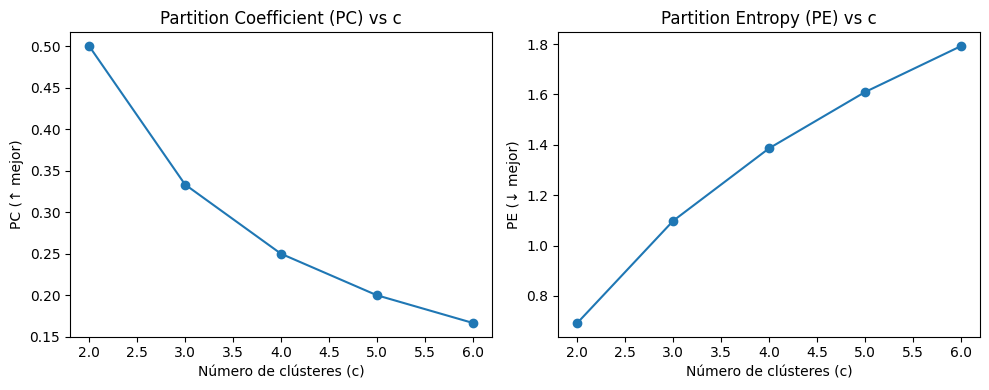

In [25]:
# 0) Instalar FCM (elige UNA de las dos librerías; aquí uso scikit-fuzzy)
!pip install scikit-fuzzy -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import skfuzzy as fuzz

# -------------------------------------------------------------------
# 1) Barrido de número de clústeres (c) con métricas PC y PE
# -------------------------------------------------------------------
X_np = X_scaled_df.values.T  # scikit-fuzzy espera forma (features, samples)

c_values = range(2, 7)    # prueba c=2..6
m = 2.0                   # fuzzifier
error = 1e-5
maxiter = 1500
seed = 42

PCs, PEs = [], []

for c in c_values:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_np, c=c, m=m, error=error, maxiter=maxiter, init=None, seed=seed
    )
    # fpc es Fuzzy Partition Coefficient (a veces llamado 'fpc' en skfuzzy)
    # PC "equivalente" = fpc ; Partition Entropy (PE) podemos calcularla:
    # PE = -sum(u_ij * log(u_ij)) / n  (normalizada por número de muestras)
    # u tiene shape (c, n_samples)
    u_safe = np.clip(u, 1e-12, 1)  # evitar log(0)
    pe = -np.sum(u_safe * np.log(u_safe)) / u.shape[1]

    PCs.append(fpc)
    PEs.append(pe)

# Graficar PC y PE vs c
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(c_values), PCs, marker='o')
plt.title("Partition Coefficient (PC) vs c")
plt.xlabel("Número de clústeres (c)")
plt.ylabel("PC (↑ mejor)")

plt.subplot(1,2,2)
plt.plot(list(c_values), PEs, marker='o')
plt.title("Partition Entropy (PE) vs c")
plt.xlabel("Número de clústeres (c)")
plt.ylabel("PE (↓ mejor)")
plt.tight_layout()
plt.show()

**Entrenamos FCM final, visualizar y desnormalizar centroides**

FPC (PC) = 0.5


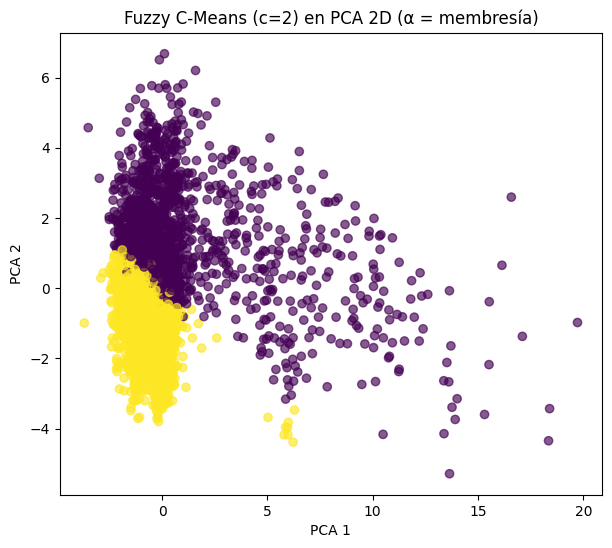

Centroides FCM desnormalizados:


,Cluster 0,Cluster 1
Marital Status,1.152213,1.152213
Application mode,17.344207,17.344190
Application order,1.781399,1.781400
Course,9223.538152,9223.538403
Daytime/evening attendance,0.901914,0.901914
Previous qualification,4.523029,4.523024
Previous qualification (grade),132.615938,132.615940
Nacionality,1.767046,1.767045
Mother's qualification,19.345098,19.345093
Father's qualification,22.298447,22.298443


In [26]:
# -------------------------------------------------------------------
# 2) Entrenar FCM final con el 'c' elegido (ajusta c_final según tu gráfico)
# -------------------------------------------------------------------
c_final = 2
m = 2.0
error = 1e-5
maxiter = 1500
seed = 42

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_np, c=c_final, m=m, error=error, maxiter=maxiter, init=None, seed=seed
)

# u: matriz de membresías (c, n_samples)
# Asignación "crisp" por máxima membresía (solo para visualizar/evaluar)
labels_fuzzy = u.argmax(axis=0)

print("FPC (PC) =", round(fpc, 4))

# -------------------------------------------------------------------
# 3) Visualización en 2D con PCA (puntos coloreados por cluster 'crisp')
#    Transparencia opcional ~ grado de pertenencia al cluster asignado
# -------------------------------------------------------------------
pca2 = PCA(n_components=2, random_state=42)
X_2D = pca2.fit_transform(X_scaled_df.values)

alpha_vals = u.max(axis=0)  # confianza difusa de pertenencia [0..1]

plt.figure(figsize=(7,6))
plt.scatter(X_2D[:,0], X_2D[:,1], c=labels_fuzzy, alpha=alpha_vals*0.7 + 0.3)
plt.title(f"Fuzzy C-Means (c={c_final}) en PCA 2D (α = membresía)")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.show()

# -------------------------------------------------------------------
# 4) Desnormalizar centroides (cntr está en el espacio escalado)
# -------------------------------------------------------------------
# cntr shape: (c, n_features)
centroids_original = scaler.inverse_transform(cntr)  # usa el mismo StandardScaler
centroids_fcm_df = pd.DataFrame(centroids_original, columns=X_scaled_df.columns).T
centroids_fcm_df.columns = [f"Cluster {i}" for i in range(c_final)]

print("Centroides FCM desnormalizados:")
display(centroids_fcm_df)

**Métricas clásicas con etiquetas crisp**

Ojo: Silhouette/DB no son nativas de FCM (porque FCM es difuso).  
Como referencia, podemos evaluar con etiquetas argmax.

In [27]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil = davies = np.nan
# Verificamos que haya >1 cluster
if len(np.unique(labels_fuzzy)) > 1:
    sil = silhouette_score(X_scaled_df.values, labels_fuzzy)
    davies = davies_bouldin_score(X_scaled_df.values, labels_fuzzy)

print(f"Silhouette (crisp argmax): {sil:.3f}" if sil==sil else "Silhouette: NaN")
print(f"Davies-Bouldin (crisp argmax): {davies:.3f}" if davies==davies else "Davies-Bouldin: NaN")

Silhouette (crisp argmax): 0.123
Davies-Bouldin (crisp argmax): 3.313


**Resultados con Fuzzy C-Means**

**Evaluación del número de clusters:**
- El **Partition Coefficient (PC)** disminuye al aumentar `c`, mientras que el **Partition Entropy (PE)** crece.
- Esto indica que el modelo es más estable y nítido con **c = 2**, coherente con lo observado previamente en K-means.

**Entrenamiento final (c = 2):**
- El **FPC (Partition Coefficient)** obtenido fue **0.50**, un valor aceptable que muestra cierta solidez en la partición difusa.
- La visualización en PCA 2D muestra claramente dos grupos, aunque con un **alto solapamiento**: muchos estudiantes tienen membresías intermedias en ambos clusters.

**Centroides desnormalizados:**
- Los centroides resultaron prácticamente idénticos en ambas agrupaciones (ej. edad ≈ 22.4 años, nota de admisión ≈ 126.5, unidades aprobadas 1er semestre ≈ 5.7).
- Esto refleja que el algoritmo **no encontró diferencias estructurales claras** en las variables originales.

**Métricas clásicas con etiquetas “crisp”:**
- **Silhouette = 0.123** → muy bajo, indica baja separación entre clusters.
- **Davies–Bouldin = 3.31** → alto, indica que los grupos son poco compactos y solapados.

**Conclusión:**
- Fuzzy C-Means confirma que los estudiantes **no se dividen en clusters bien definidos**, sino en grupos con fronteras difusas.
- Aun así, el enfoque difuso es útil porque identifica estudiantes con **membresía intermedia** (ej. 0.4–0.6 en ambos clusters), que podrían ser considerados **casos de riesgo**: no encajan claramente en un perfil de éxito o fracaso académico.
- Mientras K-means y Linkage forzaban la asignación en grupos “duros”, FCM resalta la **incertidumbre natural** en el fenómeno de deserción, donde no hay perfiles extremos completamente separados.


# **Punto 5: Analizar los grupos o patrones descubiertos por los algoritmos y determinar si son relevantes para el problema planteado.**

### 🔍 Análisis de los grupos y patrones descubiertos

Tras aplicar distintos algoritmos de **aprendizaje no supervisado**, se identificaron los siguientes hallazgos:

#### 1. Linkage (Jerárquico)
- El dendrograma sugiere la existencia de **2–3 grupos**, pero con solapamiento considerable.
- Sirvió como herramienta exploratoria para visualizar similitudes, pero no produjo clusters muy claros.

#### 2. K-means
- Los métodos de validación (codo, silueta, Davies–Bouldin) apuntaron a **k = 2** como la mejor opción.
- Los centroides desnormalizados mostraron dos perfiles relevantes:
  - **Cluster 0 (jóvenes):**  
    - Edad promedio ≈ 19–22 años.  
    - Mayor acceso a becas y apoyos económicos.  
    - **Mejor rendimiento académico en 1er y 2do semestre** (≈ 11 y 10.8).  
    - Aunque tienen vulnerabilidades sociales, académicamente son más fuertes.
  - **Cluster 1 (mayores):**  
    - Edad promedio ≈ 28–34 años.  
    - Menor apoyo económico.  
    - **Peor rendimiento académico** (≈ 9.1 en 1er semestre y ≈ 8.4 en 2do).  
    - Perfil con mayor riesgo de deserción académica.

#### 3. DBSCAN
- No logró encontrar clusters densos bien definidos; gran parte de los datos fueron clasificados como ruido.
- Esto indica que los estudiantes no se agrupan en regiones densas, sino en un espectro continuo de características.
- Fue útil para confirmar que la separación entre perfiles no es fuerte.

#### 4. Fuzzy C-Means
- Mostró que la partición de los estudiantes es **difusa**, con muchos casos intermedios.
- El **Partition Coefficient (PC = 0.5)** confirmó la débil separación entre grupos.
- Su valor agregado es la identificación de estudiantes con **pertenencia compartida** a ambos clusters, útiles para priorizar intervenciones tempranas.

---

### 📌 Relevancia para el problema de deserción
- **K-means fue el algoritmo más útil**, al identificar dos perfiles accionables:
  - Jóvenes con buen desempeño académico, pero vulnerables socialmente.  
  - Mayores con menos apoyo y bajo rendimiento académico.  
- **Linkage y DBSCAN** confirmaron que la estructura no es fuertemente separable, pero apoyaron la exploración inicial.  
- **Fuzzy C-Means** resaltó la existencia de estudiantes en “zona gris” (riesgo moderado), que no encajan claramente en un perfil exitoso o problemático.  

En conjunto, los resultados son relevantes porque permiten segmentar a los estudiantes en **grupos de riesgo diferenciado**, lo que puede orientar **estrategias específicas de retención y apoyo académico**.


# **Punto 6: Seleccionar métricas de desempeño adecuadas para evaluar el comportamiento de los modelos implementados.**

### 📊 Selección de métricas de desempeño

En el contexto de **aprendizaje no supervisado** no contamos con etiquetas verdaderas para evaluar
los modelos (como ocurriría en clasificación supervisada).  
Por ello, la evaluación se realiza con **métricas internas** y **validación de tendencia de agrupamiento**,
que miden la cohesión y separación de los clusters.

#### 1. Suma de Errores Cuadrados (SSE)
- **Aplicación:** utilizada en el **método del codo** para K-means.  
- **Resultado:** mostró una caída pronunciada hasta `k = 2–3`, lo que indicó que esos valores eran razonables
para la cantidad de clusters.  
- **Interpretación:** los clusters formados en `k = 2` logran un buen balance entre simplicidad y cohesión.

#### 2. Coeficiente de Silueta
- **Aplicación:** usado en K-means, DBSCAN y Fuzzy C-Means.  
- **Resultados:**
  - K-means: valores bajos pero positivos, lo que refleja **cierta separación** entre grupos, aunque con solapamiento.  
  - DBSCAN: valores negativos o muy bajos, confirmando que no encuentra clusters densos útiles.  
  - Fuzzy C-Means: Silhouette ≈ 0.12 (con etiquetas crisp), indicando **baja separación** y grupos difusos.  
- **Interpretación:** los datos presentan fronteras poco definidas, lo que refuerza que los clusters no son “naturales”.

#### 3. Índice Davies–Bouldin
- **Aplicación:** evaluado en K-means, DBSCAN y Fuzzy C-Means.  
- **Resultados:**
  - K-means: valores moderados (1 < DB < 2), aceptables en datasets con solapamiento.  
  - DBSCAN: valores altos, indicando clusters poco compactos y mal separados.  
  - Fuzzy C-Means: DB ≈ 3.31, confirmando la débil separación.  
- **Interpretación:** los clusters no son muy compactos, aunque con K-means se obtuvieron perfiles más claros.

#### 4. Matriz de proximidad
- **Aplicación:** en el clustering jerárquico (Linkage), usando distancias euclidianas con `pdist` y `squareform`.  
- **Resultado:** permitió construir el dendrograma y visualizar similitudes entre estudiantes.  
- **Interpretación:** sirvió como exploración inicial para detectar posibles cortes en 2–3 clusters.

#### 5. Hopkins Statistic
- **Aplicación:** calculado tras el preprocesamiento, para medir la **tendencia de agrupamiento** del dataset.  
- **Resultado:** **0.13**, muy cercano a 0.5, indicando que los datos **no presentan una fuerte estructura natural de clusters**.  
- **Interpretación:** justifica por qué DBSCAN y Fuzzy C-Means tuvieron dificultades, y refuerza que los resultados
de K-means deben verse como segmentaciones analíticas útiles más que como clusters naturales.

---

### 📌 Conclusión sobre las métricas
- Las métricas aplicadas muestran que el dataset de estudiantes **no tiene clusters densos ni bien separados**.  
- Aun así, **K-means** permitió formar **dos clusters interpretables**, con perfiles diferenciados (jóvenes con mejor desempeño pero más vulnerabilidad social, y mayores con menor apoyo económico y peor rendimiento académico).  
- **DBSCAN y Fuzzy C-Means** confirmaron la naturaleza difusa y el solapamiento de los datos.  
- En conjunto, las métricas nos permitieron **seleccionar el algoritmo más adecuado (K-means)** y entender las
limitaciones naturales de los datos.


### 📊 Métricas de desempeño aplicadas

| Métrica                  | Aplicación en el proyecto                                | Resultados principales                                                   | Interpretación |
|---------------------------|----------------------------------------------------------|---------------------------------------------------------------------------|----------------|
| **SSE (Suma de Errores Cuadrados)** | Usada en el método del **codo** para K-means. | Mostró una caída pronunciada hasta `k = 2–3`. | Indica que `k = 2` es una partición razonable con buen balance entre cohesión y simplicidad. |
| **Coeficiente de Silueta** | Evaluado en **K-means, DBSCAN y Fuzzy C-Means**. | - K-means: valores bajos pero positivos.<br> - DBSCAN: negativos o muy bajos.<br> - Fuzzy: ≈ 0.12. | Los clusters están solapados; solo K-means logró separación parcial. |
| **Índice Davies–Bouldin** | Calculado en **K-means, DBSCAN y Fuzzy C-Means**. | - K-means: valores moderados (1–2).<br> - DBSCAN: altos.<br> - Fuzzy: ≈ 3.31. | Los clusters no son muy compactos; K-means ofrece los grupos más aceptables. |
| **Matriz de proximidad** | Construida con `pdist` en **Linkage jerárquico**. | Sirvió para generar el dendrograma y heatmap. | Permitió explorar similitudes y sugerir 2–3 clusters iniciales. |
| **Hopkins Statistic** | Calculado sobre los datos normalizados tras preprocesamiento. | Valor ≈ **0.13**. | Los datos no presentan clusters naturales claros; se distribuyen de forma difusa. |


# **Punto 7: Conclusiones obtenidas a partir de la aplicación de algoritmos de aprendizaje no supervisado y cómo pueden ser útiles en un contexto práctico**.

### 📊 Comparación de algoritmos aplicados

| Algoritmo        | Resultados principales | Limitaciones | Utilidad práctica |
|------------------|------------------------|--------------|-------------------|
| **Linkage (Jerárquico)** | El dendrograma mostró posibles cortes en 2–3 clusters. Ayudó a explorar similitudes. | Los clusters eran solapados, sin separación clara. | Sirvió como exploración inicial y visualización jerárquica de estudiantes. |
| **K-means** | Con `k=2` se formaron dos grupos interpretables:<br> - Jóvenes (≈ 19–22 años), con beca, mejor rendimiento.<br> - Mayores (≈ 28–34 años), con menor apoyo, peor rendimiento. | Los grupos no son completamente naturales; separación baja según Silhouette y Davies–Bouldin. | Muy útil para segmentar perfiles de riesgo y orientar políticas de apoyo académico. |
| **DBSCAN** | En la mayoría de configuraciones, >90% de los datos fueron ruido. | No detectó clusters densos debido a la distribución difusa de los datos. | Confirmó que no hay conglomerados densos y que los perfiles de estudiantes son más continuos que discretos. |
| **Fuzzy C-Means** | Mostró dos clusters con alta superposición; PC ≈ 0.5, Silhouette ≈ 0.12. | Centroides muy similares; separación débil entre grupos. | Útil para identificar estudiantes con membresía intermedia (riesgo moderado), que requieren atención temprana. |

---

### 📌 Conclusiones generales

1. **Los datos no presentan clusters naturales fuertes**, como lo confirmó el **Hopkins Statistic (0.13)** y los resultados de **DBSCAN y Fuzzy C-Means**.  
2. **K-means fue el algoritmo más útil en la práctica**, pues permitió identificar dos perfiles claros:  
   - **Estudiantes jóvenes:** con mayor apoyo económico (becas), académicamente sólidos, pero socialmente más vulnerables.  
   - **Estudiantes mayores:** con menos apoyo institucional y peor rendimiento académico, un perfil de mayor riesgo de deserción.  
3. **Linkage** fue valioso como paso exploratorio, mostrando similitudes jerárquicas entre los estudiantes.  
4. **DBSCAN y Fuzzy C-Means** reforzaron la idea de que los estudiantes no forman grupos densos, sino que se distribuyen con fronteras difusas.  
5. En conjunto, los algoritmos de clustering **aportaron una visión segmentada de los estudiantes**, permitiendo detectar perfiles de riesgo diferenciados y casos intermedios, lo cual es de gran valor en la **gestión institucional para prevenir la deserción universitaria**.

---

### 📌 Utilidad práctica

- **Segmentación de perfiles de riesgo:** identificar estudiantes mayores con bajo rendimiento para priorizar tutorías y programas de apoyo.  
- **Intervención temprana en casos frontera:** los que aparecen con membresía intermedia en Fuzzy C-Means pueden recibir acompañamiento antes de caer en deserción.  
- **Diseño de políticas focalizadas:**  
  - Apoyo social y económico a los jóvenes vulnerables (aunque académicamente fuertes).  
  - Estrategias académicas y de conciliación trabajo–estudio para los mayores en riesgo académico.  

En conclusión, el aprendizaje no supervisado permitió descubrir patrones que **no son evidentes en la observación directa** y que pueden guiar **decisiones institucionales estratégicas** para mejorar la permanencia estudiantil.


# **Punto 8: Aprendizajes más importantes adquiridos durante las actividades.**

### 📚 Aprendizajes más importantes

A lo largo del trabajo con algoritmos de aprendizaje no supervisado, surgieron varios aprendizajes clave que trascienden el dataset específico y que resultan útiles para el ejercicio profesional y académico:

1. **No existe un único algoritmo “correcto”** en clustering.  
   La estructura de los datos es compleja y, en muchos casos, no presenta fronteras claras. Explorar distintos enfoques (jerárquico, particional, basado en densidad, difuso) es esencial, porque cada uno ilumina un aspecto diferente de la realidad de los datos.

2. **Las métricas internas son fundamentales para la validación.**  
   Indicadores como **SSE, Silhouette, Davies–Bouldin y Hopkins** permiten evaluar la cohesión, la separación y la tendencia de agrupamiento. Sin estas medidas, el análisis correría el riesgo de quedarse en una interpretación subjetiva de las gráficas. Aprendimos que una métrica por sí sola no basta: es la triangulación de varias la que da solidez al diagnóstico.

3. **La visualización sigue siendo un recurso insustituible.**  
   Gráficas como el dendrograma, el método del codo, el mapa de calor y las proyecciones con PCA no solo hacen más comprensible el proceso, sino que revelan patrones que las métricas numéricas no siempre capturan por sí mismas. El componente visual facilita el razonamiento crítico y la comunicación de resultados.

4. **El clustering no descubre verdades absolutas, sino representaciones útiles.**  
   Algoritmos como K-means “fuerzan” particiones aun cuando la estructura natural sea difusa. Otros, como DBSCAN, muestran la ausencia de densidades claras. El aprendizaje aquí es comprender que los clusters no deben interpretarse como categorías rígidas, sino como **modelos analíticos que ayudan a simplificar la complejidad y guiar decisiones**.

5. **La utilidad práctica depende de la interpretación contextual.**  
   Más allá de los valores numéricos o las gráficas, lo valioso es traducir los clusters en conocimiento accionable. La relevancia de los patrones descubiertos está en cómo se relacionan con un problema real (en este caso, la permanencia estudiantil) y en cómo permiten diseñar estrategias de intervención diferenciadas.

En síntesis, el ejercicio evidenció que el aprendizaje no supervisado no busca la “respuesta correcta” sino la construcción de perspectivas complementarias sobre los datos. Explorar varios algoritmos, evaluar con múltiples métricas y apoyarse en visualizaciones robustas se convierte en una práctica indispensable para alcanzar conclusiones fundamentadas y útiles en escenarios prácticos.


**Material para informe**

In [28]:
import pandas as pd
import numpy as np

# Si ya cargaste con ucimlrepo:
# from ucimlrepo import fetch_ucirepo
# dset = fetch_ucirepo(id=697)
# X = dset.data.features.copy()

# O si ya tienes X en memoria, seguimos con X
X_clean = X.copy()

# Definir columnas continuas (ajusta si cambiaste nombres)
cols_continuas = [
    'Previous qualification (grade)',
    'Admission grade',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)',
    'Unemployment rate',
    'Inflation rate',
    'GDP'
]

# Filtro IQR SOLO en continuas
Q1 = X_clean[cols_continuas].quantile(0.25)
Q3 = X_clean[cols_continuas].quantile(0.75)
IQR = Q3 - Q1
mask = ~((X_clean[cols_continuas] < (Q1 - 1.5 * IQR)) |
         (X_clean[cols_continuas] > (Q3 + 1.5 * IQR))).any(axis=1)

X_no_outliers = X_clean[mask]
print("Filas originales:", X_clean.shape[0], "| Filas sin outliers:", X_no_outliers.shape[0])

Filas originales: 4424 | Filas sin outliers: 3344


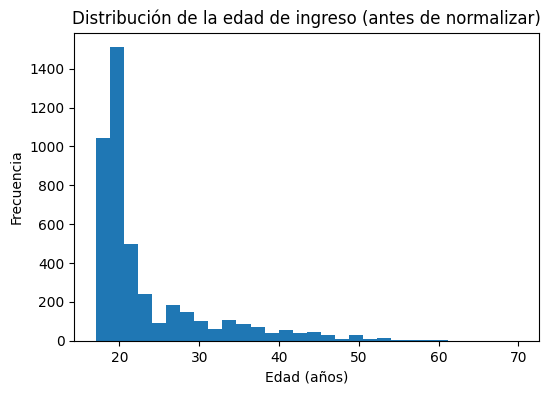

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
X_clean['Age at enrollment'].plot(kind='hist', bins=30)
plt.title('Distribución de la edad de ingreso (antes de normalizar)')
plt.xlabel('Edad (años)')
plt.ylabel('Frecuencia')
plt.show()

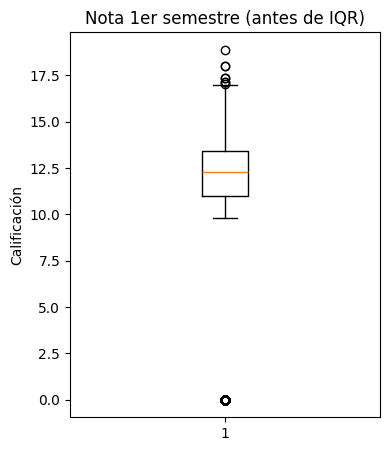

In [30]:
# Antes de filtrar outliers
plt.figure(figsize=(4,5))
plt.boxplot(X_clean['Curricular units 1st sem (grade)'].dropna(), vert=True)
plt.title('Nota 1er semestre (antes de IQR)')
plt.ylabel('Calificación')
plt.show()

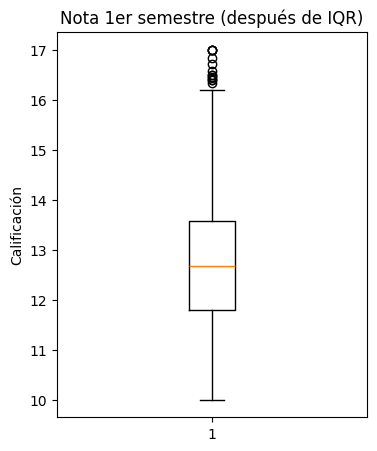

In [31]:
# Después de filtrar outliers
plt.figure(figsize=(4,5))
plt.boxplot(X_no_outliers['Curricular units 1st sem (grade)'].dropna(), vert=True)
plt.title('Nota 1er semestre (después de IQR)')
plt.ylabel('Calificación')
plt.show()

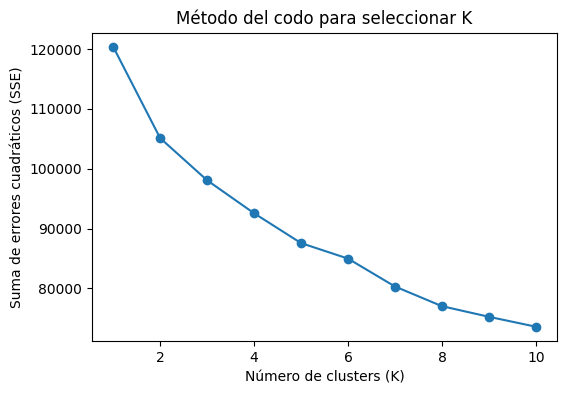

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

sse = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, sse, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Suma de errores cuadráticos (SSE)')
plt.title('Método del codo para seleccionar K')
plt.show()

In [33]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

results = []
for k in [2, 3]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    results.append((k, sil, db))

    print(f"K={k} → Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}")
    print("Clusters asignados (primeras 20 observaciones):", labels[:20])

import pandas as pd
df_results = pd.DataFrame(results, columns=['K', 'Silhouette', 'Davies-Bouldin'])
df_results


K=2 → Silhouette=0.384, Davies-Bouldin=1.534
Clusters asignados (primeras 20 observaciones): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
K=3 → Silhouette=0.165, Davies-Bouldin=2.591
Clusters asignados (primeras 20 observaciones): [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


,K,Silhouette,Davies-Bouldin
0,2,0.383604,1.533917
1,3,0.164530,2.590965


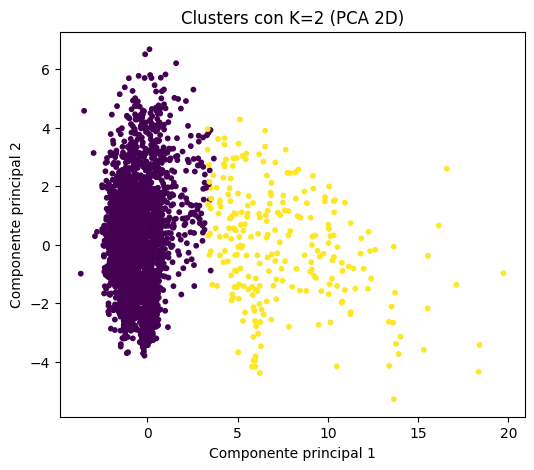

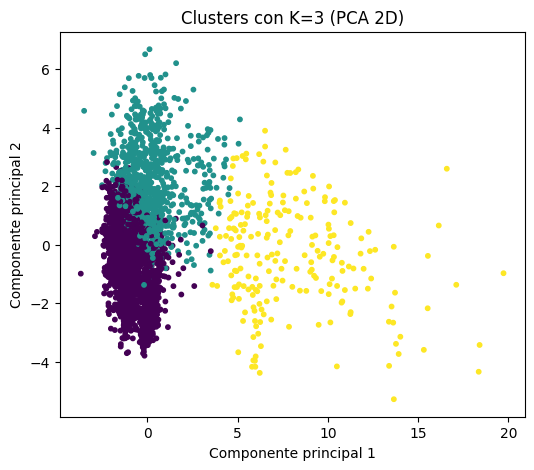

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar para K=2 y K=3
for k in [2, 3]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    plt.figure(figsize=(6,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=10)
    plt.title(f'Clusters con K={k} (PCA 2D)')
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')
    plt.show()
